# Test `isInPAIReD()` for the example of a PAIReDEllipse

In [1]:
# import all modules needed
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()

In [2]:
import sys
sys.path.insert(0, '..')
from tools.helpers import Phi_mpi_pi, deltaPhi, deltaR, shiftPhi

### Load example inputs

In [4]:
# example inputs
inputFilePath = '../../data/example_PFNano_mcRun3_EE_allPF_noBTV.root'
inputTree = uproot.open(inputFilePath)['Events']

inputBranchNames = ["PFCands_phi", "PFCands_eta", "PFCands_pt",
                    "PFCands_puppiWeight", "Jet_mass",
                    "Jet_eta", "Jet_phi", "Jet_pt", "Jet_nConstituents",
                    "Jet_jetId", "nJet"]


# load example event
i = 6
Event = inputTree.arrays(inputBranchNames, entry_start=0, entry_stop=i+1)

In [5]:
# sort the particles according to their pt
s = ak.argsort(Event.PFCands_pt, ascending=False, axis=1)
# and only include particles not considered pileup
s = s[Event.PFCands_puppiWeight[s] != 0]
phi_p = Event.PFCands_phi[s]
eta_p = Event.PFCands_eta[s]

# define 4-vector for jets in order to calculate the energy
Jcut = (Event.Jet_pt > 20) & (abs(Event.Jet_eta) < 2.5) & (Event.Jet_jetId > 4)
J4 = vector.zip({"eta": Event.Jet_eta[Jcut], "phi": Event.Jet_phi[Jcut],
        "pt": Event.Jet_pt[Jcut], "mass": Event.Jet_mass[Jcut]})
# create jet object
J = ak.zip({"phi": Event.Jet_phi[Jcut], "eta": Event.Jet_eta[Jcut],
        "pt": Event.Jet_pt[Jcut], "energy": J4.E,
        "nparticles": Event.Jet_nConstituents[Jcut],
        "index": ak.Array([np.arange(njet) for njet in Event.nJet])[Jcut]})
# get all jet pair combinations
J = ak.combinations(J, 2, axis=1, fields=["j1", "j2"],
        replacement=False)

eta_j1 = J.j1.eta
eta_j2 = J.j2.eta
phi_j1 = J.j1.phi
phi_j2 = J.j2.phi

semimajoradd = 1.

### Add dimensions

In [6]:
# in order to be able to broadcast the arrays with the particle arrays to
# the format
# (N_events, N_jetpairs, N_particles),
# we have to add one dimension to the jet related data. So, we have to add a
# one:
# (N_events, N_jetpairs) -> (N_events, N_jetpairs, 1)
eta_j1 = ak.unflatten(eta_j1, 1, axis=-1)
eta_j2 = ak.unflatten(eta_j2, 1, axis=-1)
phi_j1 = ak.unflatten(phi_j1, 1, axis=-1)
phi_j2 = ak.unflatten(phi_j2, 1, axis=-1)
# and add one to the particle related data:
# (N_events, N_particles) -> (N_events, 1, N_particles)
eta_p = ak.unflatten(eta_p, 1, axis=0)
phi_p = ak.unflatten(phi_p, 1, axis=0)

print("type of j arrays:", eta_j1.type)
print("type of p arrays:", eta_p.type)

type of j arrays: 7 * var * 1 * float32
type of p arrays: 7 * 1 * var * float32


### Determine focal points of the ellipse

In [7]:
# distance in between the jets 1 and 2
d_12 = deltaR(eta_j1, eta_j2, phi_j1, phi_j2)

# semiminor and semimajor axis of the enveloping ellipse
semiminor = 1.5
semimajor = np.maximum(semiminor, d_12/2 + semimajoradd)

# distance of focus points to center
focus = np.sqrt(semimajor**2 - semiminor**2)

# center point
eta_c = (eta_j1 + eta_j2) / 2
phi_c = Phi_mpi_pi(phi_j1 + Phi_mpi_pi(phi_j2-phi_j1) / 2)

# focus 1
eta_f1 = eta_c + focus / (d_12/2) * (eta_j1-eta_c)
phi_f1 = Phi_mpi_pi(phi_c + focus/(d_12/2) * deltaPhi(phi_j1, phi_c))

# focus 2
eta_f2 = eta_c + focus / (d_12/2) * (eta_j2-eta_c)
phi_f2 = Phi_mpi_pi(phi_c + focus/(d_12/2) * deltaPhi(phi_j2, phi_c))

### Shift particles in phi direction

In [8]:
# in order to treat the jump in the phi space from phi=pi to phi=-pi
# correctly, the phi values of the particles might have to be shifted:
#if phi_c >= 0:
#    shift = 2*np.pi
#    lim = phi_c - np.pi
#else:
#    shift = -2*np.pi
#    lim = phi_c + np.pi

# define shift and lim according to the upper if statement
shift = 2*np.pi * (phi_c>=0) - 2*np.pi * (phi_c<0)
lim = phi_c - np.pi * (phi_c>=0) + np.pi * (phi_c<0)

# eventually shift phi_p
phi_p = shiftPhi(phi_p, shift, lim)

### Calculate the distances between particles and focal points

In [9]:
# Distances to the focus points
d_f1 = np.hypot(eta_p-eta_f1, phi_p-shiftPhi(phi_f1, shift, lim))
d_f2 = np.hypot(eta_p-eta_f2, phi_p-shiftPhi(phi_f2, shift, lim))
d_sum = d_f1 + d_f2

### Return results

In [10]:
# if particle is in the ellipse,
# the sum of the distances will be less than 2*semimajor
inEllipse = d_sum < 2*semimajor
inEllipse

<Array [[], ..., [[True, False, ..., False], ...]] type='7 * var * var * bool'>

In [12]:
inEllipse[2]

<Array [[False, True, False, ..., False, False], ...] type='6 * var * bool'>

# Check output

In [13]:
import matplotlib.pyplot as plt

In [14]:
eta_p, inEllipse = ak.broadcast_arrays(eta_p, inEllipse)
phi_p, inEllipse = ak.broadcast_arrays(phi_p, inEllipse)

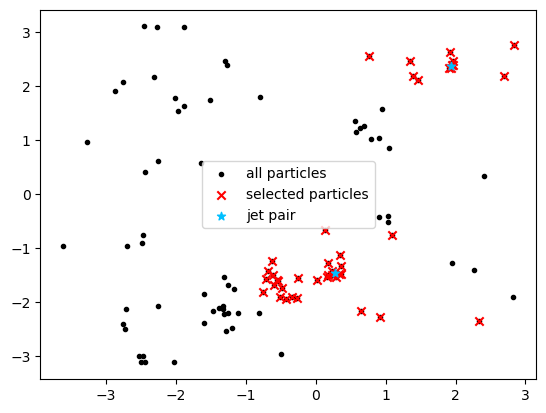

In [16]:
e = 2   # Event
i = 1   # jetpair

plt.scatter(eta_p[e,i], Phi_mpi_pi(phi_p[e,i]), color="k", marker="." , label="all particles")
plt.scatter(eta_p[inEllipse][e,i], Phi_mpi_pi(phi_p[inEllipse][e,i]), color="r", marker="x", label="selected particles")
plt.scatter([eta_j1[e,i], eta_j2[e,i]], [phi_j1[e,i], phi_j2[e,i]], color="deepskyblue", marker="*", label="jet pair")
plt.legend()

### Check out the shift phi effect

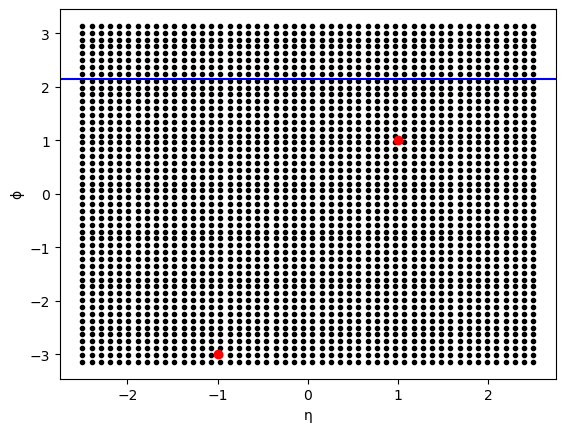

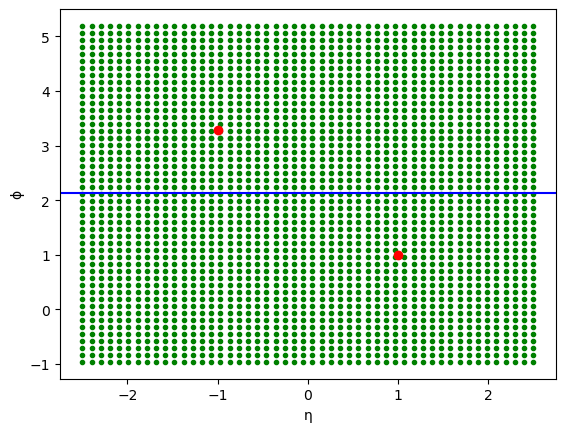

In [17]:
from tools.helpers import Phi_mpi_pi, deltaPhi, deltaR, shiftPhi
import numpy as np
import matplotlib.pyplot as plt

η = np.linspace(-2.5, 2.5)
ϕ = np.linspace(-np.pi, np.pi)
η, ϕ = np.meshgrid(η, ϕ)

η1, ϕ1 = 1, 1
η2, ϕ2 = -1, -3
ϕc = Phi_mpi_pi(ϕ1 + Phi_mpi_pi(ϕ2-ϕ1) / 2)

shift = 2*np.pi * (ϕc>=0) - 2*np.pi * (ϕc<0)
lim = ϕc - np.pi * (ϕc>=0) + np.pi * (ϕc<0)

ϕ_shifted = shiftPhi(ϕ, shift, lim) #-ϕc
ϕ1_shifted = shiftPhi(ϕ1, shift, lim) #-ϕc
ϕ2_shifted = shiftPhi(ϕ2, shift, lim) #-ϕc

plt.figure()
plt.plot(η, ϕ, ".k")
#plt.plot(η, ϕ_shifted, "xg")
plt.plot([η1,η2], [ϕ1, ϕ2], "or")
plt.axhline(ϕc, -2.5, 2.5, color="b")
plt.xlabel("η")
plt.ylabel("ϕ")
plt.show()

plt.figure()
#plt.plot(η, ϕ, ".k")
plt.plot(η, ϕ_shifted, ".g")
plt.plot([η1,η2], [ϕ1_shifted, ϕ2_shifted], "or")
plt.axhline(ϕc, -2.5, 2.5, color="b")
plt.xlabel("η")
plt.ylabel("ϕ")
plt.show()